Setup and Data Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Eyes.zip -d /content/

Archive:  /content/gdrive/MyDrive/Eyes.zip
   creating: /content/Eyes/
   creating: /content/Eyes/test/
   creating: /content/Eyes/test/cataract/
 extracting: /content/Eyes/test/cataract/cataract-100.jpg  
 extracting: /content/Eyes/test/cataract/cataract-101.jpg  
  inflating: /content/Eyes/test/cataract/cataract-103.jpg  
 extracting: /content/Eyes/test/cataract/cataract-110.jpg  
  inflating: /content/Eyes/test/cataract/cataract-117.jpg  
 extracting: /content/Eyes/test/cataract/cataract-121.jpg  
  inflating: /content/Eyes/test/cataract/cataract-122.jpg  
 extracting: /content/Eyes/test/cataract/cataract-13.jpg  
 extracting: /content/Eyes/test/cataract/cataract-135.jpg  
  inflating: /content/Eyes/test/cataract/cataract-143.jpg  
 extracting: /content/Eyes/test/cataract/cataract-168.jpg  
 extracting: /content/Eyes/test/cataract/cataract-179.jpg  
  inflating: /content/Eyes/test/cataract/cataract-190.jpg  
  inflating: /content/Eyes/test/cataract/cataract-2.jpg  
 extracting: /con

Importing Neccesary Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
import matplotlib.pyplot as plt

Data Preprocessing

In [ ]:
img_height, img_width = 64, 64
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/train",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Found 120 files belonging to 2 classes.


Visualizing the data

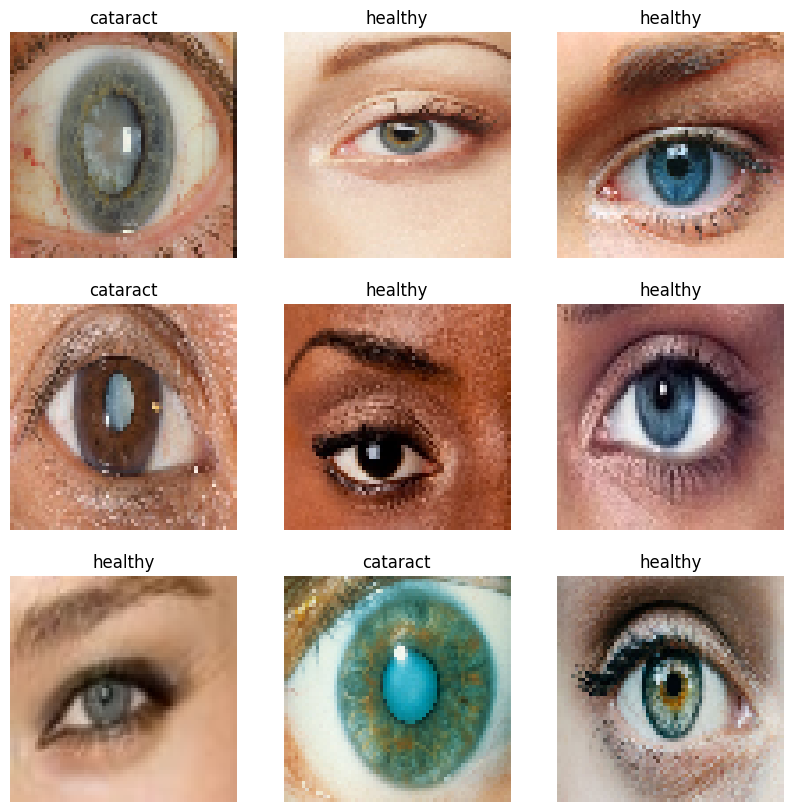

In [ ]:
class_names = ["cataract", "healthy"]
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Model Construction

In [ ]:
densenet_model = DenseNet121(include_top=False, input_shape=(img_height, img_width, 3))
densenet_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),
    densenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(2) 
])

29084464/29084464 [==============================] - 0s 0us/step



Compile the model

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Train the model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
25/25 [==============================] - 41s 1s/step - loss: 0.7677 - accuracy: 0.7575 - val_loss: 0.2805 - val_accuracy: 0.8970
Epoch 2/10
25/25 [==============================] - 30s 1s/step - loss: 0.2521 - accuracy: 0.8945 - val_loss: 0.1915 - val_accuracy: 0.9485
Epoch 3/10
25/25 [==============================] - 28s 979ms/step - loss: 0.1878 - accuracy: 0.9246 - val_loss: 0.1444 - val_accuracy: 0.9742
Epoch 4/10
25/25 [==============================] - 31s 1s/step - loss: 0.1467 - accuracy: 0.9447 - val_loss: 0.1429 - val_accuracy: 0.9657
Epoch 5/10
25/25 [==============================] - 32s 1s/step - loss: 0.1029 - accuracy: 0.9724 - val_loss: 0.1204 - val_accuracy: 0.9742
Epoch 6/10
25/25 [==============================] - 27s 903ms/step - loss: 0.0761 - accuracy: 0.9824 - val_loss: 0.0941 - val_accuracy: 0.9871
Epoch 7/10
25/25 [==============================] - 28s 912ms/step - loss: 0.0608 - accuracy: 0.9912 - val_loss: 0.0835 - val_accuracy: 0.9871
Epoch 8/10


Plot Epoch Vs Training and Validation Accuracy

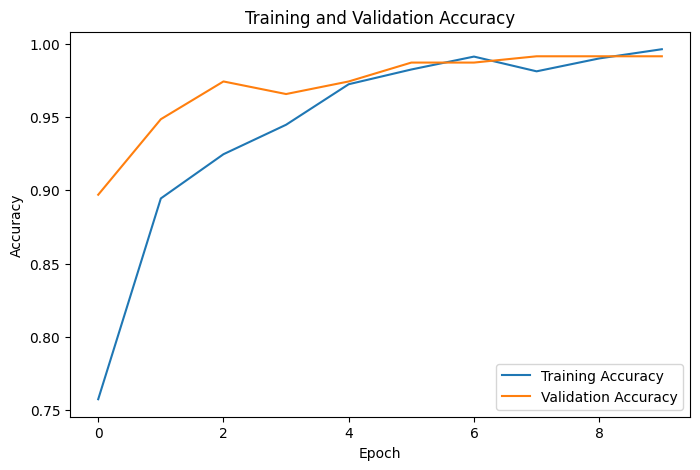

In [ ]:
import matplotlib.pyplot as plt

# Extracting accuracy history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(10)

# Plotting training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Evaluate the model

In [ ]:
model.evaluate(test_ds)

8/8 [==============================] - 7s 309ms/step - loss: 0.0379 - accuracy: 0.9911


[0.037930678576231, 0.9911110997200012]

Visualization of the Predictions

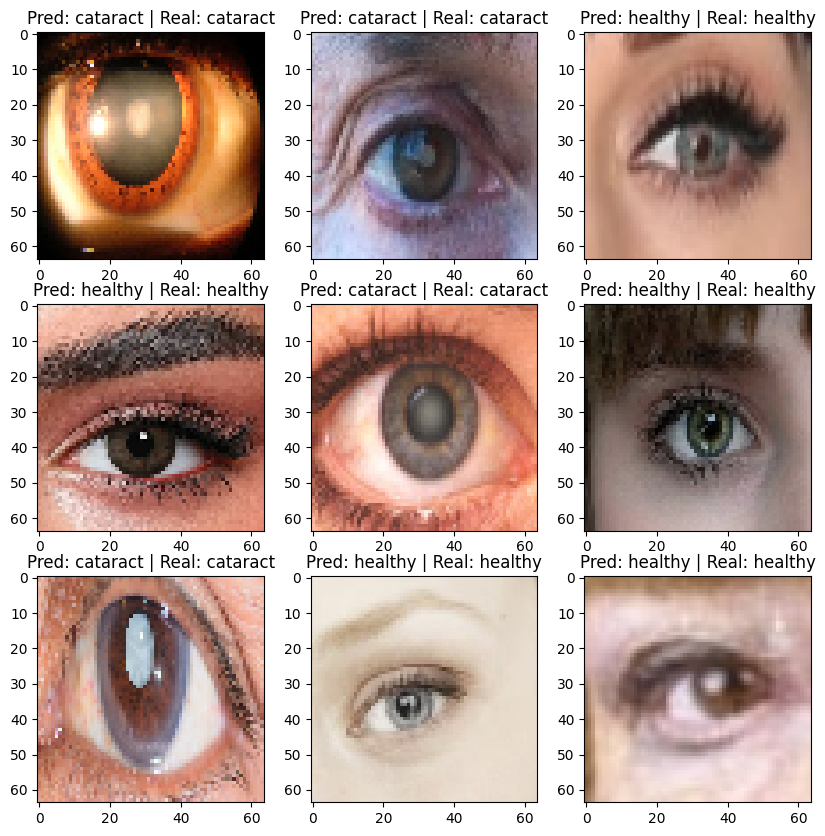

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    classifications = model(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = tf.argmax(classifications[i])
        plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])


Tflite Conversion

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

Average runtime calculation

In [ ]:
import time
# Define a function to measure the execution time of a single run
def measure_execution_time(model, input_data):
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time
# Run multiple iterations and measure the execution time for each iteration
num_iterations = 5  
total_execution_time = 0

for _ in range(num_iterations):
    execution_time = measure_execution_time(model, test_ds)
    total_execution_time += execution_time

average_execution_time = total_execution_time / num_iterations

print("Average Execution Time:", average_execution_time)

8/8 [==============================] - 7s 525ms/step
Average Execution Time: 7.0710080623626705


Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 7168962 (27.35 MB)
Trainable params: 131458 (513.51 KB)
Non-trainable params: 7037504 (26.85 MB)
___________

Calculate precision, recall, and F1 score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Predict classes for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 3s 3s/step
Precision: 0.991264367816092
Recall: 0.9911111111111112
F1 Score: 0.9911093544137023


Plot Confusion matrix

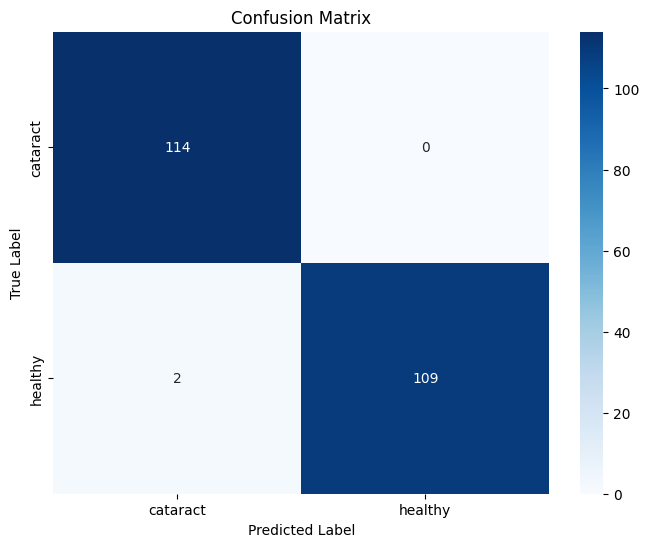

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Plot ROC CURVE

1/1 [==============================] - 0s 58ms/step


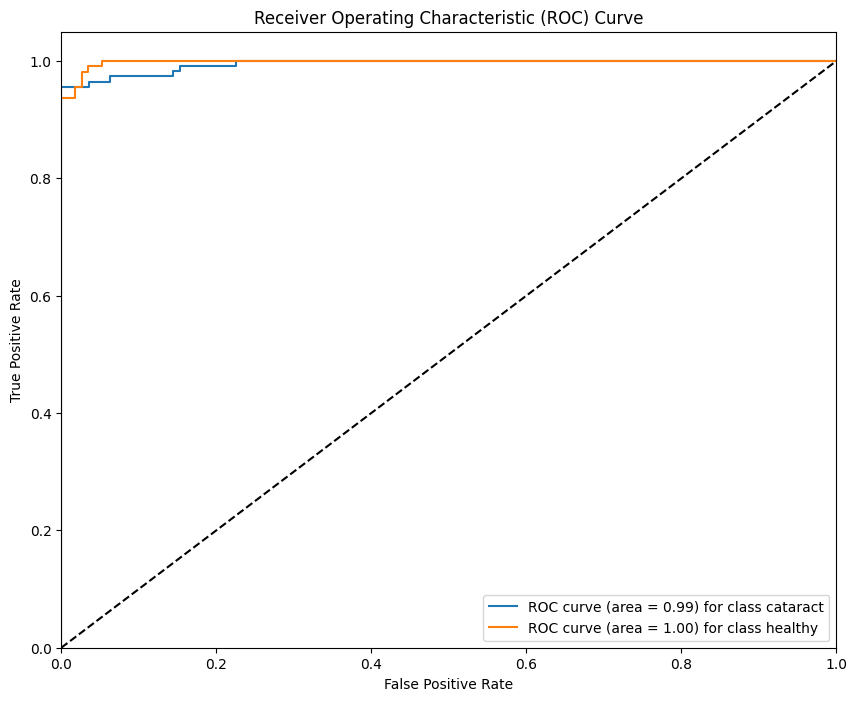

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Predict probabilities for the test dataset
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions)

# Convert the true labels to one-hot encoding
y_true = to_categorical(y_true, num_classes=len(class_names))

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], np.array(y_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()